# Analyzing the Incumbency Advantage

## Ekansh Vinaik, Matthew Chung

### Getting Started

Oftentimes in classes such as Government and Politics or U.S. History, students will learn about incumbency and how incumbent candidates are at great advantages over those who are new to the political scene in the area. The argument stems from increased funding and access to voters, along with a name brand recognition that only strengthens over time. In this notebook, we'll visualize the incumbency advantage and then make predictions using some machine learning algorithms on possible independent variables that we'll uncover in some future visualizations and analysis. The dataset we'll be using is the [State Election Results 1971-2012 dataset from Kaggle](https://www.kaggle.com/sohier/state-election-results-1971-2012). We'll start by importing some necessary modules.

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
from statsmodels.stats.proportion import proportions_ztest
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

Let's load in the dataset and see how our data is formatted. We're skipping the **data collection** phase but we should be prepared to perform some **data wrangling**. You'll see below that we already start to do so by renaming the columns and by providing the types of each column to prevent Pandas from interpreting the wrong types (this is not always necessary, however our data has an issue with being interpreted automatically).

In [2]:
df = pd.read_csv('elections/states.csv', dtype={
    'state': str,
    'district': str,
    'year': int,
    'party': str,
    'incumbent': int,
    'dem': int,
    'gop': int,
    'other': int,
}, names=['state', 'district', 'year', 'party', 'incumbent', 'dem', 'gop', 'other'], skiprows=1)

df.head()

,state,district,year,party,incumbent,dem,gop,other
0,AK,1,1992,D,0,3019,3002,0
1,AK,2,1992,D,1,4704,2169,0
2,AK,3,1992,D,1,5210,2233,0
3,AK,4,1992,R,1,1754,4538,294
4,AK,5,1992,D,1,3953,0,1153


### Data Wrangling

Having loaded in the dataset, we immediately notice a few things. First, as you can see in the table, incumbency is measured as 1 or 0 instead of True or False. Let's fix that to make it clearer for us, though our packages will not have a problem with either representation.

In [3]:
df['incumbent'] = df['incumbent'].apply(lambda x: x == 1)

Second, though it is not in the table above, there are values in party that are not D or R. We'll treat these as extraneous as we're mostly focused on incumbency with political parties as a second thought.

In [4]:
df = df[(df.party == 'D') | (df.party == 'R')]

Finally, we'll drop the other column as political party is a forethought, and then we'll sum the Democratic and GOP voter counts into a total column.

In [5]:
df = df.drop('other', axis=1).dropna()
df['total'] = df[['dem', 'gop']].sum(axis=1)

Let's view our dataframe now to see if it looks very different.

In [6]:
df.head()

,state,district,year,party,incumbent,dem,gop,total
0,AK,1,1992,D,False,3019,3002,6021
1,AK,2,1992,D,True,4704,2169,6873
2,AK,3,1992,D,True,5210,2233,7443
3,AK,4,1992,R,True,1754,4538,6292
4,AK,5,1992,D,True,3953,0,3953


In this next step, we'll predict that we won't be looking at raw counts for some step of this process, and so we'll create a new dataframe that holds the ratios of Democratic to GOP voter counts by year. We'll group by year and sum each column, dividing it by the total, to find each year's ratio.

In [7]:
years = df.groupby(['year'])
ratios = pd.DataFrame()
ratios['dem'] = years.sum()['dem'] / years.sum()['total']
ratios['gop'] = years.sum()['gop'] / years.sum()['total']
ratios = ratios.reset_index()
ratios.head()

,year,dem,gop
0,1971,0.583459,0.416541
1,1972,0.509436,0.490564
2,1973,0.660898,0.339102
3,1974,0.574307,0.425693
4,1975,0.674162,0.325838


### Exploratory Data Analysis (EDA) / Data Visualization

The next step in the data analysis process is to perform some exploratory data analysis (EDA) to discover and unearth relationships or phenomena that are not always immediately obvious. Our dataset provides us with demographic information by political party, and so we'll first look to see if there are extraneous patterns within political party voting ratios that we must consider before we look at incumbency visualizations.

Below, we create two plots. The first only shows 4 year election cycles, and the second shows 2 year election cycles. These coincide with presidential and state elections, so we can see patterns when the voting population is pushed to vote.

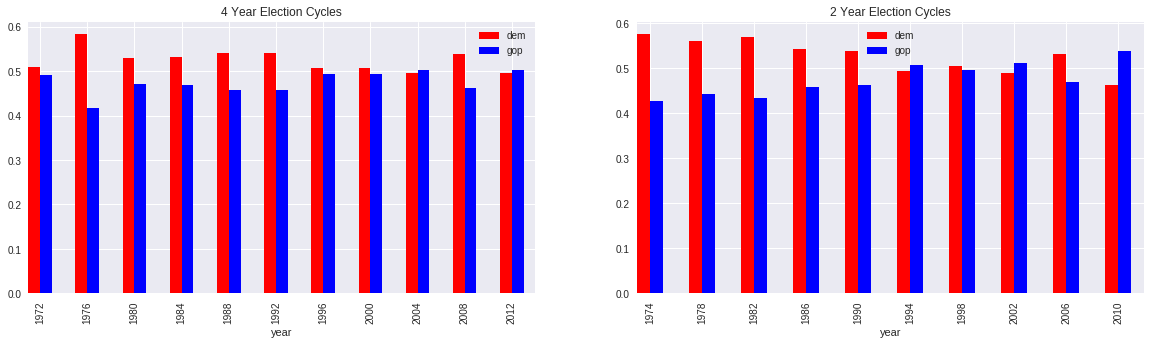

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

ratios[ratios.year % 4 == 0].plot.bar(
    x='year', y='dem', ax=axes[0], color='red', position=1, width=.25)
ratios[ratios.year % 4 == 0].plot.bar(
    x='year', y='gop', ax=axes[0], color='blue', title='4 Year Election Cycles', position=0, width=.25)
ratios[ratios.year % 4 == 2].plot.bar(
    x='year', y='dem', ax=axes[1], color='red', position=1, width=.25)
ratios[ratios.year % 4 == 2].plot.bar(
    x='year', y='gop', ax=axes[1], color='blue', title='2 Year Election Cycles', position=0, width=.25)
plt.show()

Our visualizations show some interesting insights into the data, however nothing is too extreme to consider as far as incumbency goes, at least as far as the visual representations go. We can see that the elections after Watergate had far higher turnouts of Democrats than Republicans, however over time this evens out to a more equal / less uneven ratio. Now, let's take a look at a chart of incumbent win ratios. First, we need to create a dataframe that actually holds these ratios, and thankfully Pandas has some builtin functions that will make this very simple for us.

In [9]:
inc = df.groupby('year').incumbent.value_counts(normalize=True).to_frame()
inc.columns = ['ratio']
inc = inc.reset_index()
inc.head()

,year,incumbent,ratio
0,1971,True,0.610000
1,1971,False,0.390000
2,1972,True,0.633299
3,1972,False,0.366701
4,1973,True,0.620000


Next, let's plot these ratios over time to see the how the incumbency advantage has progressed over time.

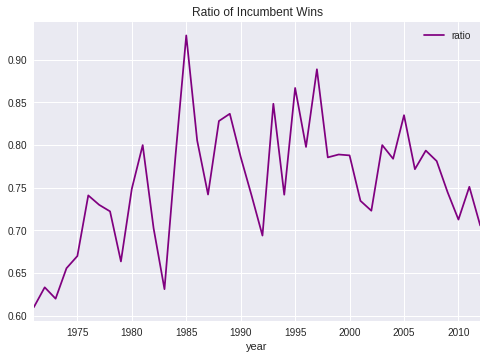

In [10]:
inc[inc.incumbent].plot.line(x='year', y='ratio', color='purple', title='Ratio of Incumbent Wins')
plt.show()

Looking at our chart above, we can see a strange drop between 1980-1985. However, aside from that year, the incumbent win ratio is clearly above 60% for nearly the entire range of years. Before we move on to some machine learning algorithms, let's verify our claim that the incumbent advantage is statistically significant. We'll perform a proportion z test with $ \alpha = .05 $ to determine if the incumbent ratio is statistically high.

In [11]:
count = df[df.incumbent].size
total = df.size
zscore, pval = proportions_ztest(count, total, 0)

display('Z-Score', zscore, 'P-Value', pval)

'Z-Score'

1325.4135573587923

'P-Value'

0.0

### Making Predictions with Machine Learning

Let's see what we can predict with some machine learning algorithms. We'll assume that our independent variables will be the state and year, and we'll determine what advantage an incumbent candidate might have. We can do this in a number of ways. First, let's start by performing some linear regression to see what results we can get out of the most simple model possible.

In [12]:
sm.ols(formula='incumbent ~ year + state', data=df).fit().params.head()

,0,1
Intercept,2.164159,-1.164159
state[T.AL],0.082895,-0.082895
state[T.AR],0.001588,-0.001588
state[T.CA],0.019500,-0.019500
state[T.CO],0.059159,-0.059159


Immediately, we notice a problem. The problem is binary classification in nature, and a linear regression model is inherently used for regression instead of classification. Thankfully, statsmodel converted our incumbency status into a numerical 0 and 1, however it does not make much sense to look at the model from this viewpoint. Instead, we can do one of two things: we can change our regression outcome to give us a ratio or we can move to a classification algorithm. Why not both?

In [13]:
sm.ols(formula='ratio ~ year', data=inc[inc.incumbent]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ratio   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     8.224
Date:                Sat, 16 Dec 2017   Prob (F-statistic):            0.00657
Time:                        18:36:32   Log-Likelihood:                 55.185
No. Observations:                  42   AIC:                            -106.4
Df Residuals:                      40   BIC:                            -102.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.0897      1.689     -2.421      0.020      -7.504      -0.675
year           0.0024      0.001      2.868      0.007       0.001       0.004
==============================================================================
Omnibus:                        2.883   Durbin-Watson:                   1.181
Prob(Omnibus):                  0.237   Jarque-Bera (JB):                2.133
Skew:                           0.548   Prob(JB):                        0.344
Kurtosis:                       3.127   Cond. No.                     3.27e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Above, we see that the coefficient for the year as far as the incumbency ratio is very small. Additionally, the P value is far above our classic $ \alpha > 0.5 $, so we can actually exclude year from our analysis and only focus on a state. Now, let's look at how we can classify each state into an incumbent preference state or not. There does exist a possibility that every single state will give an advantage to incumbents, so we should be careful with our classification. To be clear, this is not a *machine learning* classification problem: we'll loop through each state and individually print out the ones that aren't advantageous to incumbents, assuming that these even exist.

In [14]:
alpha = .05
states = []

for state in df.state.unique():
    temp = df[df.state == state].drop(['state', 'district'], axis=1)
    count = temp[temp.incumbent].size
    total = temp.size
    zscore, pval = proportions_ztest(count, total, 0)

    if pval > alpha:
        states.append(state)

states

[]

As we predicted, there are literally no states that do not provide an incumbency advantage. Instead, we can move the focus of our classification to something else. Let's think about states that are crucial in Presidential elections specifically. The pattern we notice with these states is that they are never consistently red or blue: their voting behavior is unique and changes every election cycle. We can illustrate this by first determining the states which are NEITHER red or blue from our dataset. For our purposes, we'll define this requirement as being that on average, the ratio of voters voting one way or the other is different from the other party's ratio by at least 2%. This means that the ratio must be at best 52:48.

In [15]:
alpha = .05
states = []

for state in df.state.unique():
    temp = df[df.state == state].drop(['state', 'district'], axis=1)
    count = temp.dem.sum()
    total = temp.total.sum()
    
    if abs(.5 - (count / total)) < .02:
        states.append(state)

states

['DE', 'IA', 'MT', 'NC', 'NV', 'OH', 'OK', 'OR', 'PA', 'SC', 'TN', 'WI']

Great! We've now found 12 states that are a little bit more important than the others as far as elections go because they flip flop more than others. You'll also recognize some of these states as actually being crucial states in elections, and though it's not perfect because our method of determining a state that is volatile was not perfect, it is a good enough representation for our purposes. Our next step should be to limit our dataframe with these states and take a look at its statistics to see what has changed and to see if our initial goal can be molded by what we learn from our new dataset.

Also, you'll notice that even though we're "in" the next phase of the data analysis process, we're actually moving between phases. This is a really important thing to note and learn about the data analysis timeline. This is supposed to happen! Most data science involves going back and forth between steps to constantly refine your analysis. If we were rooted in our way because that was our initial goal, then letting machines learn and process data for us would be all but futile.

In [16]:
state_df = df[df.state.isin(states)]
state_df.mean()

year          1992.672959
incumbent        0.760575
dem           7756.832590
gop           7660.240867
total        15417.073457
dtype: float64

Looking at the average statistics, we can see that our incumbent advantage ratio is still similar to our previous ratio of about .75. We also, however, see that our Democrat vs. GOP voter counts are much closer to even than we've seen previously. There are two things we have to consider at this point. First, why is the incumbency advantage so similar at all levels of analysis? How come every single state has an incumbency advantage that is so drastic? We'll discuss this below, but at this point there is no classification to be done as far as determining the advantage goes. Instead, let's perform some regression on how the incumbency advantage has changed over time, and where it might be heading in the future.

In [17]:
inc_y = df.groupby('year').mean().reset_index()
inc_y.head()

,year,incumbent,dem,gop,total
0,1971,0.610000,3364.110000,2401.690000,5765.800000
1,1972,0.633299,9569.031639,9214.540456,18783.572095
2,1973,0.620000,4063.130000,2084.760000,6147.890000
3,1974,0.655662,7136.910573,5290.084413,12426.994985
4,1975,0.670000,4044.360000,1954.730000,5999.090000


From the head of our new dataset, we can already see that there is some change in the incumbent advantage ratio over time. Let's perform some linear regression again and this time, hopefully we can incorporate some machine learning into the fact.

In [18]:
sm.ols(formula='incumbent ~ year', data=inc_y).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              incumbent   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     8.224
Date:                Sat, 16 Dec 2017   Prob (F-statistic):            0.00657
Time:                        18:36:33   Log-Likelihood:                 55.185
No. Observations:                  42   AIC:                            -106.4
Df Residuals:                      40   BIC:                            -102.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.0897      1.689     -2.421      0.020      -7.504      -0.675
year           0.0024      0.001      2.868      0.007       0.001       0.004
==============================================================================
Omnibus:                        2.883   Durbin-Watson:                   1.181
Prob(Omnibus):                  0.237   Jarque-Bera (JB):                2.133
Skew:                           0.548   Prob(JB):                        0.344
Kurtosis:                       3.127   Cond. No.                     3.27e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Great! We can see that there is some sort of noticeable coefficient with the change in incumbency attached to year, and the P value is significant ($ 0.007 < \alpha = .05 $). Finally, we've found a noticeable change and we can perform some machine learning with it. Let's use a support vector machine (SVM) regression algorithm from scikit-learn ([read about it here](http://scikit-learn.org/stable/modules/svm.html)) to predict how the incumbency advantage ratio will change over time.

In [19]:
X = inc_y.year.values.reshape(-1, 1)
y = inc_y.incumbent
clf = svm.SVR()
clf.fit(X, y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Now that we've fit our model (with all of our data instead of test and train: we'll do that soon), we can try some numbers to see if they work. Let's see if we can make reasonable predictions about the incumbency advantage using decimal years.

In [20]:
clf.predict([[1972.4], [1982.4], [2010]])

array([ 0.72548716,  0.73855197,  0.75759672])

We find that our incumbency advantage is definitely increasing over time according to our fitted SVM. However, we must remember that our SVM is only of degree 3, so perhaps a higher degree might show a different trend in the change of data. Let's perform a cross validation score procedure to determine how our current algorithm performs ([read about it here](http://scikit-learn.org/stable/modules/cross_validation.html)).

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

clf = svm.SVR()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.08694445998485556

Great! Our algorithm seems to be close to 0. Let's try this by calculating the average score over a number of *folds* ([read about it here for a previous tutorial](https://github.com/evinaik/cmsc320-project3/blob/master/Project%203.ipynb), [or here](http://scikit-learn.org/stable/modules/cross_validation.html)). We'll use a number of splits (in this case 10) to determine if our SVM is really as great as it seems. We're also using a scoring mechanism called "neg_mean_squared_error" to make our results a little more human readable. This will return negative values of the MSE, but it's simply the sign flipped. It's a result of the implementation of the algorithm and changes made in very recent versions.

In [22]:
clf = svm.SVR()
cross_val_score(clf, X, y, cv=10, scoring='neg_mean_squared_error')

array([-0.02016392, -0.00223709, -0.00569159, -0.0112378 , -0.00285032,
       -0.00546903, -0.005687  , -0.00105228, -0.00201399, -0.00122587])

Fortunately, it really looks like our SVM does perform as great as, if not better than our simple linear regression. While we could probably determine the point at which the SVM starts outperforming the linear regression or vice versa, it's really not quite necessary. Just for kicks, let's see what the incumbency advantage looks like for a few years.

In [23]:
clf = svm.SVR()
clf.fit(X_train, y_train)
clf.predict([[1970], [2017], [2020]])

array([ 0.74438459,  0.76217301,  0.76217301])

Interesting! According to our algorithm, the incumbency advantage ratio has evened out right about now, and while that may not be accurate, there's not much more to say from our dataset about future years until we're actually in them.

### Conclusion / Policy Decision

Looking back at our entire timeline, our original goal was to visualize the incumbency advantage and determine if there was some kind of prediction we could make about it. While we initially thought that we could predict if the incumbency advantage existed based on the year and the state, we made further and further strides until finding that **every** state has an incumbency advantage of some sort that is, for our intents and purposes, disprovable. As data scientists, this is part of the process, and the best thing we can do is make some other kind of related prediction that still provides us insights that are useful for other reasons.

In our case, we decided that determining a good regression fit and predicting the ratio of the incumbency advantage (incumbency wins over total wins) was a good way to move forward. We found that both linear regression and an SVM regression were ways to solve this problem.

Our intention with this entire tutorial was to show that the data analysis timeline is both interesting and complex. We hope that some of the links we provided were helpful in understanding the less obvious and more complex operations performed in the article, and we encourage any readers to perform some data analysis on their own, no matter how big or small! Thanks for reading!